<a href="https://colab.research.google.com/github/NNRahat/PyTorch_projects/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# device agnostic code

In [ ]:
device = "cude" if torch.cuda.is_available() else "cpu"
device

'cude'

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("Data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exist...skipping download.")
else:
  print(f"{image_path} doesn't exist. creating one.....")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading zip file........")
  f.write(request.content)

# unzipping the zip file 
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping the zipfile.....")
  zip_ref.extractall(image_path)



Data/pizza_steak_sushi doesn't exist. creating one.....
downloading zip file........
unzipping the zipfile.....


In [ ]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(filenames)} images {len(dirnames)} directories in {dirpath}") 

In [ ]:
walk_through_dir(image_path)

there are 0 images 2 directories in Data/pizza_steak_sushi
there are 0 images 3 directories in Data/pizza_steak_sushi/test
there are 31 images 0 directories in Data/pizza_steak_sushi/test/sushi
there are 19 images 0 directories in Data/pizza_steak_sushi/test/steak
there are 25 images 0 directories in Data/pizza_steak_sushi/test/pizza
there are 0 images 3 directories in Data/pizza_steak_sushi/train
there are 72 images 0 directories in Data/pizza_steak_sushi/train/sushi
there are 75 images 0 directories in Data/pizza_steak_sushi/train/steak
there are 78 images 0 directories in Data/pizza_steak_sushi/train/pizza


In [ ]:
train_dir = image_path / "train"

test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('Data/pizza_steak_sushi/train'),
 PosixPath('Data/pizza_steak_sushi/test'))

image height: 512
image width: 512


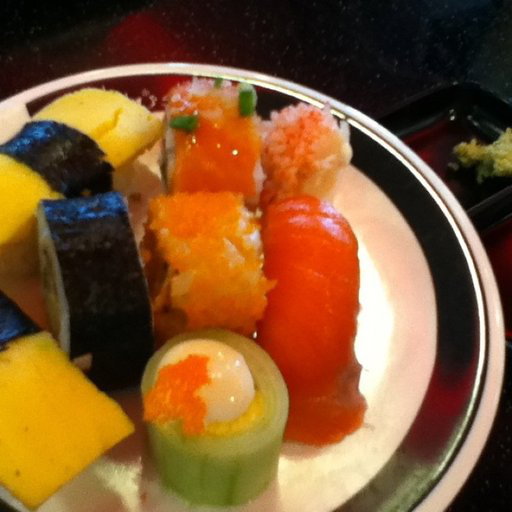

In [ ]:
from PIL import Image
import random

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"image height: {img.height}")
print(f"image width: {img.width}")

img

### with matplotlib

Its a pizza and the shape is (512, 512, 3)


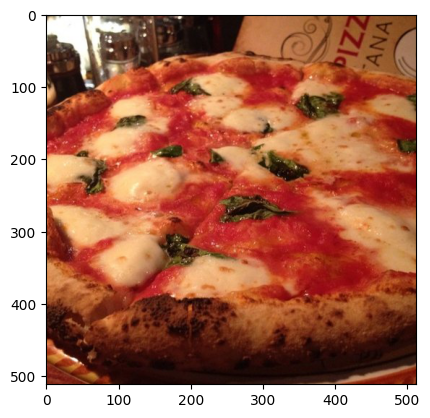

In [ ]:
import numpy as np

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image = random.choice(image_path_list)
img = Image.open(random_image)
img_as_array = np.asarray(img)
plt.imshow(img_as_array)
print(f"Its a {random_image.parent.stem} and the shape is {img_as_array.shape}")
# random_image

### transforming data

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # resize the image to 64 x 64
    transforms.Resize(size=(64, 64)),
    # flip the image horizontally on probability 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    # convert the image into tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

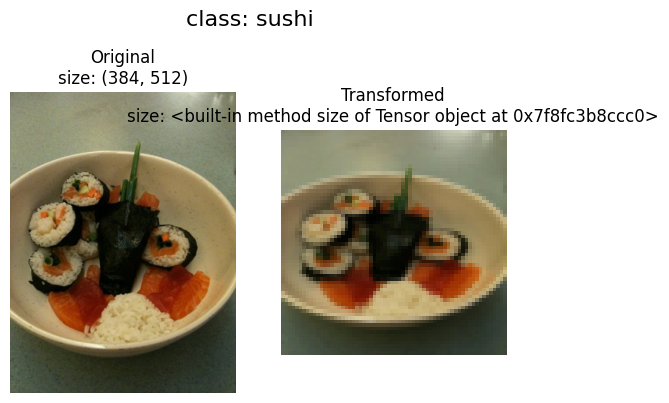

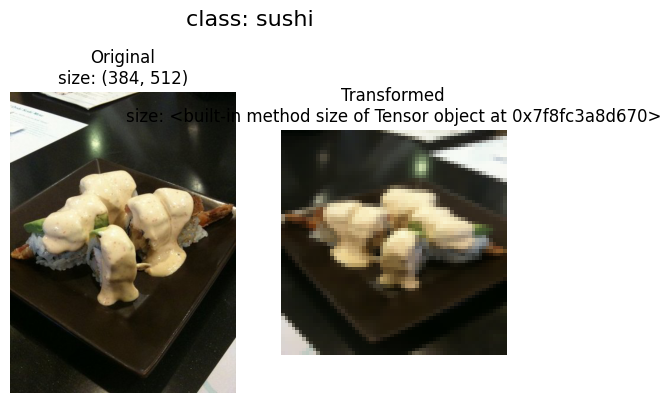

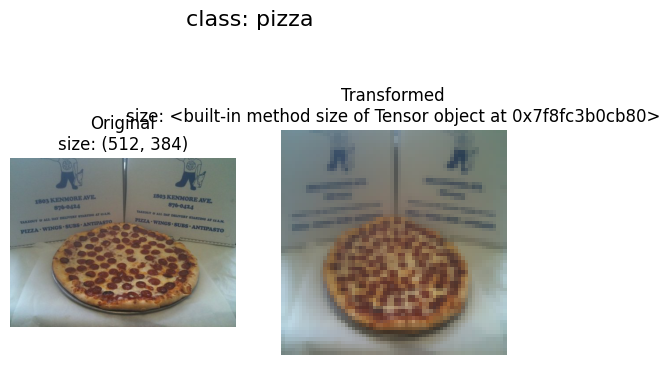

In [25]:
def plot_transformed_image(image_path:list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_path, k=n)
  for image_path in random_image_paths:
    # for the actual image
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nsize: {f.size}")
      ax[0].axis(False)
    
      # for the transformed image
      transformed_image = transform(f).permute(1,2,0) # C X H X W -> H X W X C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nsize: {transformed_image.size}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_image(image_path = image_path_list,
                       transform = data_transform,
                       n=3,
                       seed = None)




In [26]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: Data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: Data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [28]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [33]:
train_data.samples[0]

('Data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)